# Objective:
To group unlabeled customer questions from the amazon-top-cell-phones-and-accessories-qa dataset into distinct semantic clusters. The goal is to identify and rank the most frequent tasks (intents) that users are trying to accomplish (e.g., checking compatibility, verifying physical dimensions, inquiring about battery life) to inform chatbot logic or product page optimizations.


# Load Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("validmodel/amazon-top-cell-phones-and-accessories-qa")

print("Path to dataset files:", path)

100%|██████████| 6.95M/6.95M [00:00<00:00, 203MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/validmodel/amazon-top-cell-phones-and-accessories-qa/versions/28


# Install required packages

In [ ]:
!pip install --quiet gensim nltk gradio scikit-learn matplotlib pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 99.6 MB/s eta 0:00:00


# Read Data

In [ ]:
import pandas as pd
import ast

file_path = path + "/qa_Cell_Phones_and_Accessories.json"
rows = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                row = ast.literal_eval(line)
                rows.append(row)
            except Exception as e:
                pass

df = pd.DataFrame(rows)

In [ ]:
df.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer
0,yes/no,1466736038,"Mar 8, 2014",1.394266e+09,Is there a SIM card in it?,Y,Yes. The Galaxy SIII accommodates a micro SIM ...
1,open-ended,1466736038,"Aug 4, 2014",1.407136e+09,Why hasnt it upgraded to latest Android OS 4.4...,NaN,"My S3 was able to upgrade to 4.4.2 last week, ..."
2,yes/no,1466736038,"Jan 29, 2015",1.422518e+09,"Is this phone new, with 1 year manufacture war...",?,It is new but I was not able to get it activat...
3,yes/no,1466736038,"Nov 30, 2014",1.417334e+09,can in it be used abroad with a different carr...,Y,Yes
4,yes/no,1466736038,"Nov 24, 2014",1.416816e+09,Is this phone brand new and NOT a mini?,?,The phone we received was exactly as described...


In [ ]:
df.shape

(85865, 7)

# FILTER YES/NO QUESTIONS

In [ ]:
df = df.dropna(subset=["question"])

In [ ]:
df_yes = df[df["questionType"] == "yes/no"].copy()

In [ ]:
df_yes.shape

(48900, 7)

In [ ]:
df_yes.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer
0,yes/no,1466736038,"Mar 8, 2014",1.394266e+09,Is there a SIM card in it?,Y,Yes. The Galaxy SIII accommodates a micro SIM ...
2,yes/no,1466736038,"Jan 29, 2015",1.422518e+09,"Is this phone new, with 1 year manufacture war...",?,It is new but I was not able to get it activat...
3,yes/no,1466736038,"Nov 30, 2014",1.417334e+09,can in it be used abroad with a different carr...,Y,Yes
4,yes/no,1466736038,"Nov 24, 2014",1.416816e+09,Is this phone brand new and NOT a mini?,?,The phone we received was exactly as described...
7,yes/no,1466736038,"Oct 2, 2014",1.412233e+09,Does this phone use the regular Sim card (the ...,?,it takes mini sim


# TEXT PREPROCESSING

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Build Normalization Pipeline

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

LEM = WordNetLemmatizer()

# Base stopwords
_default_stopwords = set(stopwords.words("english"))

# Keep question-intent modifiers
question_modifiers = {'does','do','did','will','would','can','could','is','are','was','were','has','have','had','should'}

_CUSTOM_STOPWORDS = _default_stopwords - question_modifiers

def normalize_text(text):
    """
    Full text normalization pipeline:
    1. Lowercase
    2. Remove punctuation except measurements (e.g., 5g, 12mm)
    3. Tokenize
    4. Remove stopwords but keep intent-related question words
    5. Lemmatize
    """
    if not isinstance(text, str):
        return ""

    t = text.lower().strip()

    # Remove punctuation except alphanumerics
    t = re.sub(r"[^a-z0-9\s]", " ", t)

    # Normalize whitespace
    t = re.sub(r"\s+", " ", t).strip()

    # Tokenize
    tokens = nltk.word_tokenize(t)

    # Remove stopwords (custom)
    tokens = [w for w in tokens if w not in _CUSTOM_STOPWORDS]

    # Lemmatize
    tokens = [LEM.lemmatize(w) for w in tokens]

    return " ".join(tokens)


Apply Cleaning

In [ ]:
df_yes["clean"] = df_yes["question"].apply(normalize_text)

In [ ]:
df_yes = df_yes[df_yes["clean"].str.strip() != ""]

In [ ]:
df_yes[["question", "clean"]].head()

,question,clean
0,Is there a SIM card in it?,is sim card
2,"Is this phone new, with 1 year manufacture war...",is phone new 1 year manufacture warranty
3,can in it be used abroad with a different carr...,can used abroad different carrier
4,Is this phone brand new and NOT a mini?,is phone brand new mini
7,Does this phone use the regular Sim card (the ...,doe phone use regular sim card bigger sim card


# WORD2VEC VECTORIZATION

In [ ]:
from gensim.models import Word2Vec

# Tokenize cleaned text for word2vec
df_yes["tokens"] = df_yes["clean"].apply(lambda x: nltk.word_tokenize(x))

# Train Word2Vec on the dataset
w2v_model = Word2Vec(
    sentences=df_yes["tokens"],
    vector_size=200,
    window=5,
    sg=1,          # Skip-gram for better semantics
    min_count=2,
    workers=4,
    epochs=15
)

Convert each question to a vector (average of word embeddings)

In [ ]:
import numpy as np

def sent_vector(tokens):
    """Returns mean vector of word embeddings for each sentence."""
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    if len(vecs) == 0:
        return np.zeros(200)
    return np.mean(vecs, axis=0)

df_yes["vector"] = df_yes["tokens"].apply(sent_vector)
X = np.vstack(df_yes["vector"].to_numpy())
X.shape

(48900, 200)

# DIMENSIONALITY REDUCTION (PCA)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(48900, 50)

# CLUSTERING WITH K-MEANS

Find optimal k (Optional — Silhouette)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = {}
for k in range(5, 21):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_reduced)
    s = silhouette_score(X_reduced, labels)
    scores[k] = s

scores

{5: np.float32(0.08649383),
 6: np.float32(0.088510334),
 7: np.float32(0.091389686),
 8: np.float32(0.09645938),
 9: np.float32(0.09299446),
 10: np.float32(0.09516266),
 11: np.float32(0.09841233),
 12: np.float32(0.103060305),
 13: np.float32(0.106864415),
 14: np.float32(0.10999647),
 15: np.float32(0.11097312),
 16: np.float32(0.113418035),
 17: np.float32(0.10579998),
 18: np.float32(0.109059185),
 19: np.float32(0.10966584),
 20: np.float32(0.11114881)}

Choose K (e.g., 12 clusters)

In [ ]:
from sklearn.cluster import KMeans

K = 12
kmeans = KMeans(n_clusters=K, random_state=42)
df_yes["cluster"] = kmeans.fit_predict(X_reduced)
df_yes["cluster"].value_counts()


,count
cluster,
2,7706
4,5667
6,5501
8,5166
7,4551
5,4534
0,4286
10,3149
1,2905


# ANALYSIS — Label Clusters & Extract Intent Keywords

TF-IDF keywords per cluster

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

cluster_keywords = {}

for c in range(K):
    cluster_texts = df_yes[df_yes["cluster"] == c]["clean"].tolist()

    vectorizer = TfidfVectorizer(max_features=20)
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)

    keywords = vectorizer.get_feature_names_out()
    cluster_keywords[c] = keywords

cluster_keywords

{0: array(['5c', 'can', 'case', 'compatible', 'do', 'doe', 'fit', 'have',
        'ipad', 'iphone', 'ipod', 'is', 'lifeproof', 'nexus', 'otterbox',
        'phone', 'plus', 'will', 'work', 'would'], dtype=object),
 1: array(['back', 'button', 'call', 'camera', 'can', 'case', 'cover', 'do',
        'doe', 'flash', 'front', 'ha', 'have', 'is', 'language', 'nfc',
        'phone', 'support', 'wifi', 'work'], dtype=object),
 2: array(['anyone', 'are', 'back', 'battery', 'can', 'case', 'cover', 'do',
        'doe', 'fit', 'get', 'ha', 'have', 'is', 'like', 'one', 'phone',
        'use', 'will', 'work'], dtype=object),
 3: array(['battery', 'belt', 'box', 'case', 'charger', 'clip', 'come',
        'cord', 'do', 'doe', 'have', 'holster', 'include', 'is',
        'original', 'phone', 'product', 'strap', 'tool', 'warranty'],
       dtype=object),
 4: array(['battery', 'bluetooth', 'cable', 'can', 'case', 'charge',
        'charger', 'charging', 'device', 'do', 'doe', 'have', 'iphone',
        'i

Get representative question (closest to centroid)

In [ ]:
def representative_question(df_cluster, centroid_vec):
    """
    Returns the question closest to cluster centroid
    using PCA-reduced vectors (same used for KMeans)
    """
    vectors = np.vstack(df_cluster["vector_reduced"].to_numpy())
    dists = np.linalg.norm(vectors - centroid_vec, axis=1)
    idx = np.argmin(dists)
    return df_cluster.iloc[idx]["question"]


In [ ]:
X_reduced = pca.fit_transform(X)  # shape (n_samples, 50)
df_yes["vector_reduced"] = list(X_reduced)


In [ ]:
reps = {}
for c in range(K):
    df_cluster = df_yes[df_yes["cluster"] == c]
    centroid = kmeans.cluster_centers_[c]
    reps[c] = representative_question(df_cluster, centroid)

reps


{0: 'I have an iphone 5s, will this fit it? Thx.',
 1: 'Does the flashlight have any emergency strobe function?',
 2: 'I love how slim and light my new S4 is. I want to purchase a case that can maintain this quality close to intact. Is this case light/slim enough?',
 3: 'does it come with waranty',
 4: 'I would like to leave this permanently plugged into the wall and use it as a charging base for my nightly recharge of my phone and bluetooth headset. My New Trent: iCarrier IMP1000 does this. Will this do the same?',
 5: 'will this phone work with t-mobile, also will it work overseases including the Philippines, Eurpoe?',
 6: 'Will this also fit the Huawei Ascend Y330?',
 7: 'Can you use tis phone for pageplus',
 8: 'Will a samsung galaxy s blaze w/out a case fit here?',
 9: 'Does it fit with the Moshi iVisor AG screen protector? Other cases cause the screen protector to roll up, since it covers the entire face of the phone.',
 10: 'Is this unlocked, I notice this is the cheapest out of

# 2D VISUALIZATION

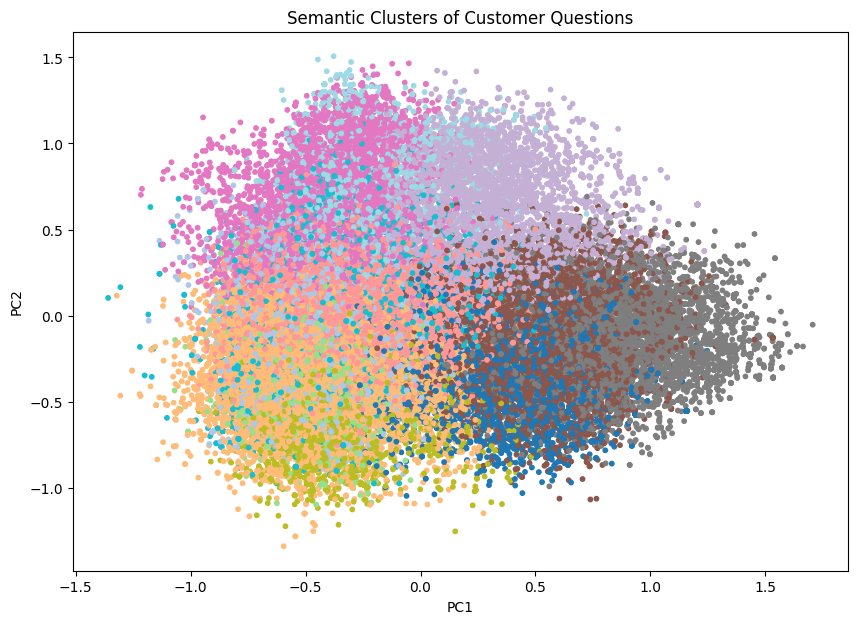

In [ ]:
import matplotlib.pyplot as plt

pca2 = PCA(n_components=2)
X_2d = pca2.fit_transform(X_reduced)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df_yes["cluster"], cmap="tab20", s=10)
plt.title("Semantic Clusters of Customer Questions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# **FINAL DELIVERABLE — Ranked Intents**

In [ ]:
intent_summary = (
    df_yes.groupby("cluster")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="count")
)

intent_summary["percentage"] = (
    intent_summary["count"] / intent_summary["count"].sum() * 100
).round(2)

intent_summary


,cluster,count,percentage
0,2,7706,15.76
1,4,5667,11.59
2,6,5501,11.25
3,8,5166,10.56
4,7,4551,9.31
5,5,4534,9.27
6,0,4286,8.76
7,10,3149,6.44
8,1,2905,5.94
9,3,1882,3.85
